In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go

%load_ext autoreload
%autoreload 2

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

In [3]:
scores_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\users_with_scores.parquet')
scores_ddf = scores_ddf.compute()
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0


In [4]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf = ratings_ddf.compute()
ratings_ddf.head()

,date,bid,uid,rating,has_review,review,compound
0,2015-08-20 10:00:00,142544,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0
1,2015-11-14 11:00:00,120824,nmann08.184925,3.56,False,None,0
2,2011-11-18 11:00:00,47581,nmann08.184925,4.50,False,None,0
3,2013-05-03 10:00:00,93113,nmann08.184925,3.75,False,None,0
4,2015-01-24 11:00:00,875,nmann08.184925,3.81,False,None,0


In [5]:
beers_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\beers.parquet')
beers_ddf = beers_ddf.compute()
beers_ddf.head()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


# Goal of the analysis (beer style):
1) what types of beers are rated more by each categories relative to their number of ratings
2) what type of beer each category like more (ie. are the ratings better for some category of beers)

## What style of beer are more rated by each category

In [6]:
# get user for each category
cfm_users = scores_ddf[scores_ddf["is_cfm"] == True]
exp_users = scores_ddf[scores_ddf["is_exp"] == True]
xpl_users = scores_ddf[scores_ddf["is_xpl"] == True]
adv_users = scores_ddf[scores_ddf["is_adv"] == True]

# group by rating for each category
cfm_ratings = ratings_ddf[ratings_ddf["uid"].isin(cfm_users["uid"])]
exp_ratings = ratings_ddf[ratings_ddf["uid"].isin(exp_users["uid"])]
xpl_ratings = ratings_ddf[ratings_ddf["uid"].isin(xpl_users["uid"])]
adv_ratings = ratings_ddf[ratings_ddf["uid"].isin(adv_users["uid"])]



In [7]:
cfm_ratings

,date,bid,uid,rating,has_review,review,compound
1862,2014-01-25 11:00:00,19827,jaydoc.265507,3.25,False,None,0
1863,2014-01-25 11:00:00,20842,jaydoc.265507,3.75,False,None,0
1864,2013-11-27 11:00:00,4720,jaydoc.265507,3.50,False,None,0
1865,2013-11-27 11:00:00,41037,jaydoc.265507,4.00,False,None,0
1866,2013-11-27 11:00:00,41012,jaydoc.265507,4.00,False,None,0
...,...,...,...,...,...,...,...
154230,2005-11-15 11:00:00,1505,tboom29.8226,3.59,True,This beer pours a very dark auburn red. The no...,0
154284,2005-11-17 11:00:00,25684,skittlebrau.41838,4.43,True,"Wow, where do I start with this one. Well, as ...",0
154328,2013-10-25 10:00:00,70471,hipboy221.727431,3.75,False,None,0
154334,2015-01-29 11:00:00,141790,johlac66.829174,4.38,False,None,0


In [8]:
# get style of beer for each bid
cfm_ratings = cfm_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
exp_ratings = exp_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
xpl_ratings = xpl_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
adv_ratings = adv_ratings.merge(beers_ddf[["bid", "style"]], on="bid")
overall_ratings = ratings_ddf.merge(beers_ddf[["bid", "style"]], on="bid")

In [115]:
overall_ratings.shape

(7654894, 8)

In [116]:
# count of each style for each category
cfm_style_count = cfm_ratings.groupby("style").count()["uid"]
exp_style_count = exp_ratings.groupby("style").count()["uid"]
xpl_style_count = xpl_ratings.groupby("style").count()["uid"]
adv_style_count = adv_ratings.groupby("style").count()["uid"]
overall_style_count = overall_ratings.groupby("style").count()["uid"]


In [117]:
# normalize count of each style for each category by number of ratings for each category
cfm_style_count = cfm_style_count / cfm_ratings.shape[0]
exp_style_count = exp_style_count / exp_ratings.shape[0]
xpl_style_count = xpl_style_count / xpl_ratings.shape[0]
adv_style_count = adv_style_count / adv_ratings.shape[0]
overall_style_count = overall_style_count / overall_ratings.shape[0]

In [118]:
# sort by highest count
cfm_style_count = cfm_style_count.sort_values(ascending=False)
exp_style_count = exp_style_count.sort_values(ascending=False)
xpl_style_count = xpl_style_count.sort_values(ascending=False)
adv_style_count = adv_style_count.sort_values(ascending=False)
overall_style_count = overall_style_count.sort_values(ascending=False)

In [119]:
# get top 10 styles for each category
cfm_style_count = cfm_style_count[:10]
exp_style_count = exp_style_count[:10]
xpl_style_count = xpl_style_count[:10]
adv_style_count = adv_style_count[:10]
overall_style_count = overall_style_count[:10]

Goal: obtain the percentage of rating for each style of beer(percent in terms of their total number of rating) for each category of users

In [120]:
overall_style_count

style
American IPA                        0.120096
American Double / Imperial IPA      0.089675
American Double / Imperial Stout    0.060493
American Pale Ale (APA)             0.046723
Saison / Farmhouse Ale              0.036436
American Wild Ale                   0.032632
American Porter                     0.031244
Russian Imperial Stout              0.030692
American Amber / Red Ale            0.024390
Fruit / Vegetable Beer              0.020014
Name: uid, dtype: float64

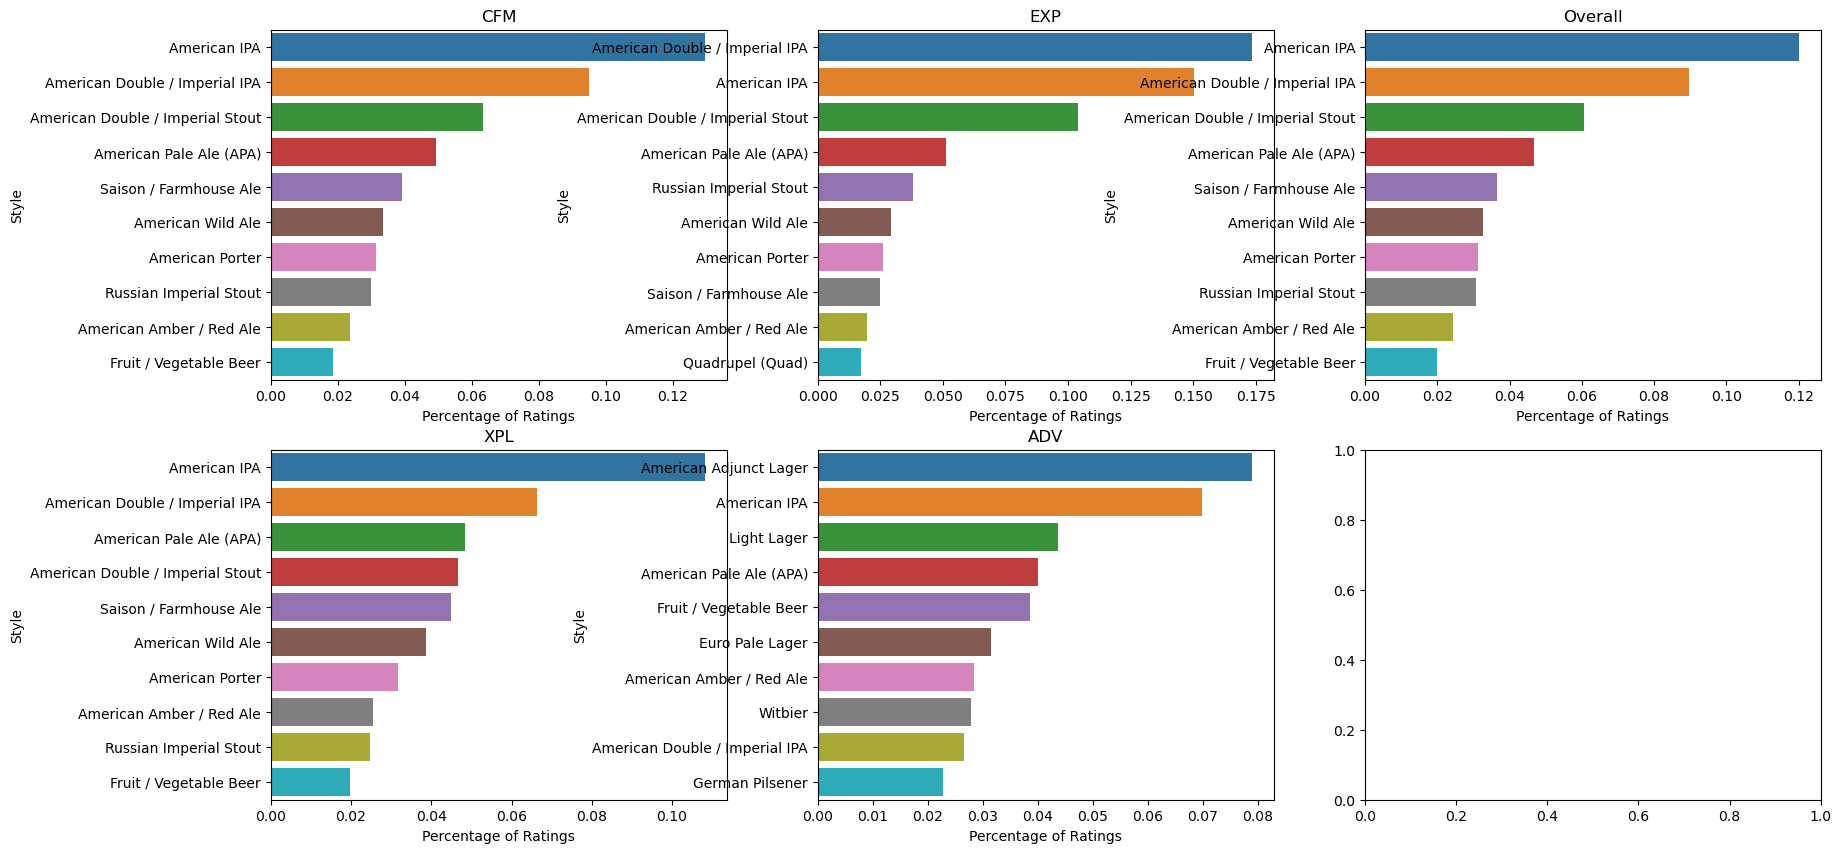

In [122]:
# plot top 10 styles for each category(and overall) using style_count using seaborn on 5 subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.barplot(x=cfm_style_count.values, y=cfm_style_count.index, ax=axs[0, 0])
sns.barplot(x=exp_style_count.values, y=exp_style_count.index, ax=axs[0, 1])
sns.barplot(x=xpl_style_count.values, y=xpl_style_count.index, ax=axs[1, 0])
sns.barplot(x=adv_style_count.values, y=adv_style_count.index, ax=axs[1, 1])
sns.barplot(x=overall_style_count.values, y=overall_style_count.index, ax=axs[0, 2])

axs[0, 0].set_title("CFM")
axs[0, 1].set_title("EXP")
axs[1, 0].set_title("XPL")
axs[1, 1].set_title("ADV")
axs[0, 2].set_title("Overall")

axs[0, 0].set_xlabel("Percentage of Ratings")
axs[0, 1].set_xlabel("Percentage of Ratings")
axs[1, 0].set_xlabel("Percentage of Ratings")
axs[1, 1].set_xlabel("Percentage of Ratings")
axs[0, 2].set_xlabel("Percentage of Ratings")

axs[0, 0].set_ylabel("Style")
axs[0, 1].set_ylabel("Style")
axs[1, 0].set_ylabel("Style")
axs[1, 1].set_ylabel("Style")
axs[0, 2].set_ylabel("Style")

plt.show()







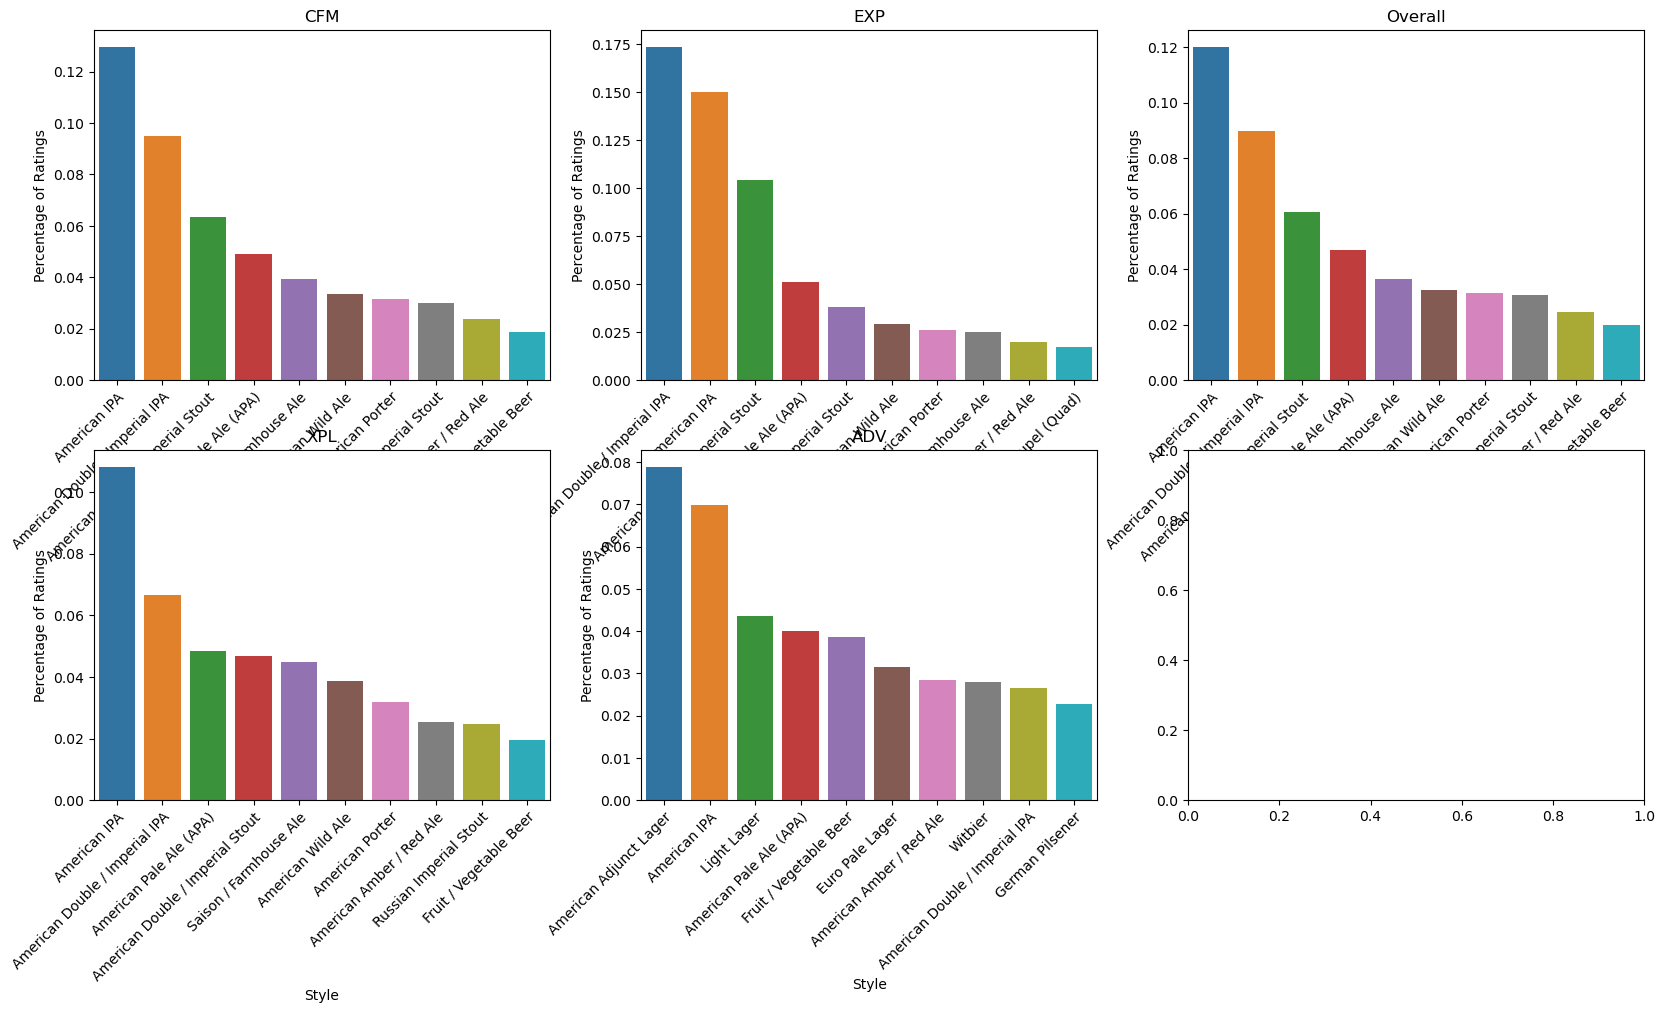

In [123]:
# same plot as above but with vertical bars and make the text diagonal under the bars
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.barplot(y=cfm_style_count.values, x=cfm_style_count.index, ax=axs[0, 0])
sns.barplot(y=exp_style_count.values, x=exp_style_count.index, ax=axs[0, 1])
sns.barplot(y=xpl_style_count.values, x=xpl_style_count.index, ax=axs[1, 0])
sns.barplot(y=adv_style_count.values, x=adv_style_count.index, ax=axs[1, 1])
sns.barplot(y=overall_style_count.values, x=overall_style_count.index, ax=axs[0, 2])

axs[0, 0].set_title("CFM")
axs[0, 1].set_title("EXP")
axs[1, 0].set_title("XPL")
axs[1, 1].set_title("ADV")
axs[0, 2].set_title("Overall")

axs[0, 0].set_ylabel("Percentage of Ratings")
axs[0, 1].set_ylabel("Percentage of Ratings")
axs[1, 0].set_ylabel("Percentage of Ratings")
axs[1, 1].set_ylabel("Percentage of Ratings")
axs[0, 2].set_ylabel("Percentage of Ratings")

axs[0, 0].set_xlabel("Style")
axs[0, 1].set_xlabel("Style")
axs[1, 0].set_xlabel("Style")
axs[1, 1].set_xlabel("Style")
axs[0, 2].set_xlabel("Style")

plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[0, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[0, 2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [124]:
# create interactive vertical bar plot of top 10 styles for each category using style_count
# you can click on a category to display it and the plot are superimposed on each other

import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Bar(
    y=cfm_style_count.values,
    x=cfm_style_count.index,
    name="CFM",
    orientation='v',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    y=exp_style_count.values,
    x=exp_style_count.index,
    name="EXP",
    orientation='v',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar(
    y=xpl_style_count.values,
    x=xpl_style_count.index,
    name="XPL",
    orientation='v',

    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    y=adv_style_count.values,
    x=adv_style_count.index,
    name="ADV",
    orientation='v',
    marker_color='#FFFF00'
))
fig.add_trace(go.Bar(
    y=overall_style_count.values,
    x=overall_style_count.index,
    name="Overall",
    orientation='v',
    marker_color='#FF00FF'
))





# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_style_count.index})

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Percentage of Ratings")

# set the title
fig.update_layout(title_text="Top 10 rated beer styles for each Category")

fig.update_layout(barmode='group')
fig.show()


In [129]:
# same plot as above but when you click on a category it will be sorted by that category

fig = go.Figure()


fig.add_trace(go.Bar(
    y=cfm_style_count.values,
    x=cfm_style_count.index,
    name="CFM",
    orientation='v',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    y=exp_style_count.values,
    x=exp_style_count.index,
    name="EXP",
    orientation='v',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar(
    y=xpl_style_count.values,
    x=xpl_style_count.index,
    name="XPL",
    orientation='v',

    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    y=adv_style_count.values,
    x=adv_style_count.index,
    name="ADV",
    orientation='v',
    marker_color='#FFFF00'
))

fig.add_trace(go.Bar(
    y=overall_style_count.values,
    x=overall_style_count.index,
    name="Overall",
    orientation='v',
    marker_color='#FF00FF'
))


# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_style_count.index})

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Percentage of Ratings")

# set the title
fig.update_layout(title_text="Top 10 rated beer styles for each Category")

fig.update_layout(barmode='group')

# add a dropdown menu to select the category
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="CFM",
                        method="update",
                        args=[{"visible": [True, False, False, False, False]},
                            {"title": "CFM",
                            "xaxis": {'categoryorder':'array', 'categoryarray':cfm_style_count.index}}]),
                dict(label="EXP",
                        method="update",
                        args=[{"visible": [False, True, False, False, False]},
                            {"title": "EXP",
                            "xaxis": {'categoryorder':'array', 'categoryarray':exp_style_count.index}}]),
                dict(label="XPL",
                        method="update",
                        args=[{"visible": [False, False, True, False, False]},
                            {"title": "XPL",
                            "xaxis": {'categoryorder':'array', 'categoryarray':xpl_style_count.index}}]),
                dict(label="ADV",
                        method="update",
                        args=[{"visible": [False, False, False, True, False]},
                            {"title": "ADV",
                            "xaxis": {'categoryorder':'array', 'categoryarray':adv_style_count.index}}]),
                dict(label="Overall",
                        method="update",
                        args=[{"visible": [False, False, False, False, True]},
                            {"title": "Overall",
                            "xaxis": {'categoryorder':'array', 'categoryarray':overall_style_count.index}}]),

            ]),
        )
    ])

fig.show()



In [89]:
cfm_ratings.head()

,date,bid,uid,rating,has_review,review,compound,style
0,2014-01-25 11:00:00,19827,jaydoc.265507,3.25,False,None,0,English Pale Ale
1,2012-12-02 11:00:00,19827,byofb.537281,3.50,False,None,0,English Pale Ale
2,2012-07-14 10:00:00,19827,othershoe2.233642,3.68,True,Pours a rich brownish red with some chill haze...,0,English Pale Ale
3,2012-01-02 11:00:00,19827,animal69.160100,3.50,False,None,0,English Pale Ale
4,2011-09-07 10:00:00,19827,treyliff.490010,3.62,True,Pours a dark brown with a decent creamy head. ...,0,English Pale Ale


## What style of beer are more liked by each category

In [130]:
# group by cfm_ratings by style and get average rating for each style
cfm_ratings_by_style = cfm_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
exp_ratings_by_style = exp_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
xpl_ratings_by_style = xpl_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
adv_ratings_by_style = adv_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)
overall_ratings_by_style = overall_ratings.groupby('style').mean().sort_values(by='rating', ascending=False)

# normalize the avg ratings by dividing by the average rating for all their ratings
cfm_ratings_by_style['norm_rating'] = cfm_ratings_by_style['rating'] / cfm_ratings['rating'].mean()
exp_ratings_by_style['norm_rating'] = exp_ratings_by_style['rating'] / exp_ratings['rating'].mean()
xpl_ratings_by_style['norm_rating'] = xpl_ratings_by_style['rating'] / xpl_ratings['rating'].mean()
adv_ratings_by_style['norm_rating'] = adv_ratings_by_style['rating'] / adv_ratings['rating'].mean()
overall_ratings_by_style['norm_rating'] = overall_ratings_by_style['rating'] / overall_ratings['rating'].mean()

In [131]:
# get the top 10 styles for each category
cfm_ratings_by_style_top10 = cfm_ratings_by_style.head(10)
exp_ratings_by_style_top10 = exp_ratings_by_style.head(10)
xpl_ratings_by_style_top10 = xpl_ratings_by_style.head(10)
adv_ratings_by_style_top10 = adv_ratings_by_style.head(10)
overall_ratings_by_style_top10 = overall_ratings_by_style.head(10)

In [104]:
cfm_ratings_by_style_top10

,bid,rating,has_review,compound,norm_rating
style,,,,,
Gueuze,41152.901423,4.279337,0.239643,0.0,1.090345
American Double / Imperial Stout,95337.416583,4.271372,0.217386,0.0,1.088315
Russian Imperial Stout,58034.193964,4.204332,0.275130,0.0,1.071234
Quadrupel (Quad),53387.653710,4.185874,0.302674,0.0,1.066531
Flanders Red Ale,62750.630511,4.172130,0.246463,0.0,1.063029
Eisbock,27121.087607,4.170085,0.413462,0.0,1.062508
American Wild Ale,124768.935140,4.162731,0.166163,0.0,1.060634
American Double / Imperial IPA,95953.064451,4.161204,0.230712,0.0,1.060245
English Barleywine,68887.504606,4.152700,0.310747,0.0,1.058079


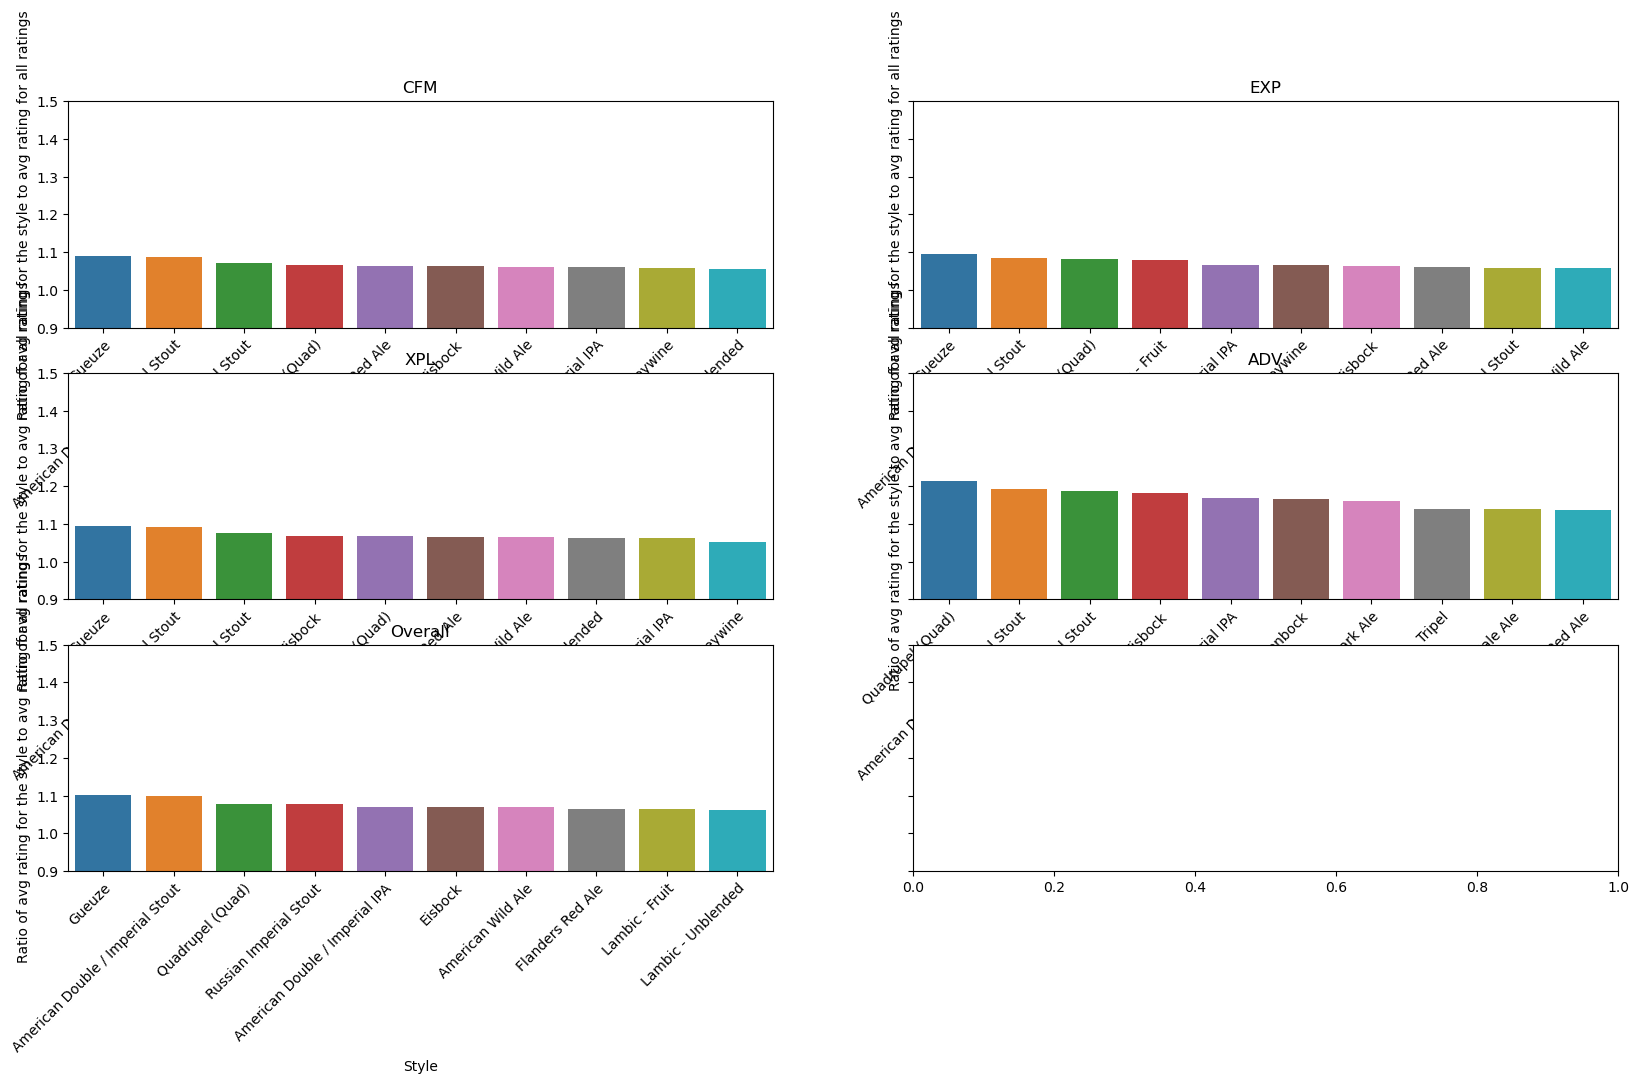

In [132]:
# plot the top 10 styles for each category
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharey=True)
sns.barplot(y=cfm_ratings_by_style_top10["norm_rating"].values, x=cfm_ratings_by_style_top10.index, ax=axs[0, 0])
sns.barplot(y=exp_ratings_by_style_top10["norm_rating"].values, x=exp_ratings_by_style_top10.index, ax=axs[0, 1])
sns.barplot(y=xpl_ratings_by_style_top10["norm_rating"].values, x=xpl_ratings_by_style_top10.index, ax=axs[1, 0])
sns.barplot(y=adv_ratings_by_style_top10["norm_rating"].values, x=adv_ratings_by_style_top10.index, ax=axs[1, 1])
sns.barplot(y=overall_ratings_by_style_top10["norm_rating"].values, x=overall_ratings_by_style_top10.index, ax=axs[2, 0])

axs[0, 0].set_title("CFM")
axs[0, 1].set_title("EXP")
axs[1, 0].set_title("XPL")
axs[1, 1].set_title("ADV")
axs[2, 0].set_title("Overall")

axs[0, 0].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[0, 1].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[1, 0].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[1, 1].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")
axs[2, 0].set_ylabel("Ratio of avg rating for the style to avg rating for all ratings")

axs[0, 0].set_xlabel("Style")
axs[0, 1].set_xlabel("Style")
axs[1, 0].set_xlabel("Style")
axs[1, 1].set_xlabel("Style")
axs[2, 0].set_xlabel("Style")

plt.setp(axs[0, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[0, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[1, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(axs[2, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# make the plot start at y = 0.9
axs[0, 0].set_ylim(0.9, 1.5)
axs[0, 1].set_ylim(0.9, 1.5)
axs[1, 0].set_ylim(0.9, 1.5)
axs[1, 1].set_ylim(0.9, 1.5)
axs[2, 0].set_ylim(0.9, 1.5)


plt.show()

In [135]:
# make the plot interactive
fig = go.Figure()

fig.add_trace(go.Bar(
    x=cfm_ratings_by_style_top10.index,
    y=cfm_ratings_by_style_top10["norm_rating"].values,
    name='CFM',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    x=exp_ratings_by_style_top10.index,
    y=exp_ratings_by_style_top10["norm_rating"].values,
    name='EXP',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar(
    x=xpl_ratings_by_style_top10.index,
    y=xpl_ratings_by_style_top10["norm_rating"].values,
    name='XPL',
    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    x=adv_ratings_by_style_top10.index,
    y=adv_ratings_by_style_top10["norm_rating"].values,
    name='ADV',
    marker_color='#FFFF00'
))

fig.add_trace(go.Bar(
    x=overall_ratings_by_style_top10.index,
    y=overall_ratings_by_style_top10["norm_rating"].values,
    name='Overall',
    marker_color='#000000'
))

# set y axis to start at 0.9 and end at 1.2
fig.update_yaxes(range=[0.9, 1.2])



# Change the bar mode
fig.update_layout(barmode='group', title="Top 10 Styles by Avg Rating for Each category")
fig.show()


TODO: 1) add in the analysis the baseline of all users regardless of category (DONE) 
2) analysis of where the rating of each category go to (which country eg. belgium beers)  
3) where do the users of each category come from 
4) discuss with the group with plot to keep and do analysis on them: numbers, distribution, difference, similarity
5) clean the kept plots (colors label, size, legend,... )

# To which country (country of the beer) the ratings of each category go ?

## Where are user of each category comming from ? (is there any difference) ?

In [215]:
# use cfm_users, exp_users, xpl_users, adv_users, and overall_users to get countries of users
xpl_users_by_country = xpl_users.groupby("country").count()
adv_users_by_country = adv_users.groupby("country").count()
exp_users_by_country = exp_users.groupby("country").count()
cfm_users_by_country = cfm_users.groupby("country").count()
overall_users_by_country = scores_ddf.groupby("country").count()

# get the top 4 countries for each category
xpl_users_by_country_top10 = xpl_users_by_country.sort_values(by="uid", ascending=False).head(4)
adv_users_by_country_top10 = adv_users_by_country.sort_values(by="uid", ascending=False).head(4)
exp_users_by_country_top10 = exp_users_by_country.sort_values(by="uid", ascending=False).head(4)
cfm_users_by_country_top10 = cfm_users_by_country.sort_values(by="uid", ascending=False).head(4)
overall_users_by_country_top10 = overall_users_by_country.sort_values(by="uid", ascending=False).head(4)




In [220]:
# interactive pie chart with plotly for top 5 countries for each category
# you can choose a category to show and display the top 5 countries for that category
# you can also choose to show all categories at once

# make the plot interactive
fig = go.Figure()

# define the colors for each country blue, red, yellow, green, purple
colors = ['#0000FF', '#FF0000', '#FFFF00', '#00FF00', '#800080']

fig.add_trace(go.Pie(
    labels=xpl_users_by_country_top10.index,
    values=xpl_users_by_country_top10["uid"].values,
    name='XPL'

))
fig.add_trace(go.Pie(
    labels=adv_users_by_country_top10.index,
    values=adv_users_by_country_top10["uid"].values,
    name='ADV'
))
fig.add_trace(go.Pie(
    labels=exp_users_by_country_top10.index,
    values=exp_users_by_country_top10["uid"].values,
    name='EXP'
))
fig.add_trace(go.Pie(
    labels=cfm_users_by_country_top10.index,
    values=cfm_users_by_country_top10["uid"].values,
    name='CFM'
))
fig.add_trace(go.Pie(
    labels=overall_users_by_country_top10.index,
    values=overall_users_by_country_top10["uid"].values,
    name='Overall'
))

# create a dropdown menu to choose which category to show (default is overall)
fig.update_layout(
    updatemenus=[
        dict(
            active=4,
            buttons=list([
                dict(label="XPL",
                        method="update",
                        args=[{"visible": [True, False, False, False, False]},
                            {"title": "Top 4 Countries for XPL"}]),
                dict(label="ADV",
                        method="update",
                        args=[{"visible": [False, True, False, False, False]},
                            {"title": "Top 4 Countries for ADV"}]),
                dict(label="EXP",
                        method="update",
                        args=[{"visible": [False, False, True, False, False]},
                            {"title": "Top 4 Countries for EXP"}]),
                dict(label="CFM",
                        method="update",
                        args=[{"visible": [False, False, False, True, False]},
                            {"title": "Top 4 Countries for CFM"}]),
                dict(label="Overall",
                        method="update",
                        args=[{"visible": [False, False, False, False, True]},
                            {"title": "Top 4 Countries for Overall"}]),
            ]), 
        )
    ])

fig.update_layout(title_text="Top 4 Countries for Each Category")

fig.show()


There are more canadian for explorer and adventurer because they are probably more likely to rate canadian beers (which are more rare)

##  To which country do the ratings for each category go to ?

In [115]:
BEERS_PATH = "Data/BeerAdvocate/beers.csv"
beers_df = pd.read_csv(BEERS_PATH)
beers_df.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [116]:
# load breweries data
BREWERIES_PATH = "Data/BeerAdvocate/breweries.csv"
breweries_df = pd.read_csv("Data/BeerAdvocate/breweries.csv")
breweries_df.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [117]:
# merge beers and breweries locations
beers_breweries_df = pd.merge(beers_df, breweries_df, left_on="brewery_id", right_on="id", how="left")
beers_breweries_df.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,id,location,name,nbr_beers
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5


In [118]:
# only keep beer_id and location
beers_breweries_df = beers_breweries_df[["beer_id", "location", "nbr_ratings"]]
beers_breweries_df.head()

,beer_id,location,nbr_ratings
0,166064,Kyrgyzstan,0
1,166065,Kyrgyzstan,0
2,166066,Kyrgyzstan,0
3,166067,Kyrgyzstan,0
4,166063,Kyrgyzstan,0


In [119]:
# group by location and count number of ratings
beers_breweries_df = beers_breweries_df.groupby("location").agg({"nbr_ratings": "sum"})
beers_breweries_df.head()

,nbr_ratings
location,
Albania,83
Algeria,17
Andorra,26
Angola,6
Antigua & Barbuda,51


In [120]:
# sort by number of ratings
beers_breweries_df = beers_breweries_df.sort_values(by="nbr_ratings", ascending=False)
beers_breweries_df.head(10)

,nbr_ratings
location,
"United States, California",1384998
"United States, Colorado",484803
"United States, Michigan",479548
"United States, New York",458950
"United States, Massachusetts",411348
Belgium,406845
"United States, Pennsylvania",349511
"United States, Oregon",307641
"United States, Illinois",281906


In [121]:
beers_breweries_df = pd.merge(beers_df, breweries_df, left_on="brewery_id", right_on="id", how="left")
beers_breweries_df.head()

# only keep beer_id and location
beers_breweries_df = beers_breweries_df[["beer_id", "location"]]


In [122]:
# merge with ratings
beers_breweries_ratings_df = pd.merge(beers_breweries_df, ratings_ddf, left_on="beer_id", right_on="bid", how="left")
beers_breweries_ratings_df.head()

,beer_id,location,date,bid,uid,rating,has_review,review,compound
0,166064,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,166065,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,166066,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,166067,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,166063,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# merge with scores_df
beers_breweries_ratings_scores_df = pd.merge(beers_breweries_ratings_df, scores_ddf, left_on="uid", right_on="uid", how="left")

In [124]:
beers_breweries_ratings_scores_df.head()

,beer_id,location_x,date,bid,uid,rating,has_review,review,compound,n_ratings,...,location_y,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,166064,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
1,166065,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
2,166066,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
3,166067,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
4,166063,Kyrgyzstan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN


In [125]:
# filter out nan ratings
beers_breweries_ratings_scores_df = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["rating"].notna()]
beers_breweries_ratings_scores_df.head()

,beer_id,location_x,date,bid,uid,rating,has_review,review,compound,n_ratings,...,location_y,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
23,142544,Gabon,2015-08-20 10:00:00,142544.0,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0.0,7820.0,...,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0.0,0.0,1.0,0.0
24,19590,Northern Ireland,2009-02-20 11:00:00,19590.0,stjamesgate.163714,3.67,True,Pours pale copper with a thin head that quickl...,0.0,2521.0,...,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0.0,0.0,1.0,0.0
25,19827,Northern Ireland,2014-12-01 11:00:00,19827.0,hellpop65.48993,3.25,False,None,0.0,2326.0,...,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0.0,0.0,0.0,0.0
26,19827,Northern Ireland,2014-05-29 10:00:00,19827.0,latarnik.52897,3.50,False,None,0.0,3098.0,...,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0.0,0.0,0.0,1.0
27,19827,Northern Ireland,2014-02-26 11:00:00,19827.0,rochefortchris.697017,3.50,False,None,0.0,1866.0,...,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0.0,0.0,1.0,0.0


In [126]:
# group by location and count number of ratings per location
location_count = beers_breweries_ratings_scores_df.groupby("location_x").agg({"rating": "count"})

# sort by number of ratings
location_count = location_count.sort_values(by="rating", ascending=False)
location_count.head(10)

,rating
location_x,
"United States, California",1281068
"United States, Colorado",450813
"United States, Michigan",446570
"United States, New York",429100
"United States, Massachusetts",385638
Belgium,338880
"United States, Pennsylvania",327811
"United States, Oregon",283117
"United States, Illinois",264166


In [127]:
# get list of locations with less than 100 ratings
locations_to_remove = location_count[location_count["rating"] < 100].index
locations_to_remove

Index(['Haiti', 'Canada, Alberta',
       'United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://theram.com" target="_blank">theram.com',
       'Uruguay', 'Montenegro', 'Egypt', 'Tanzania',
       'Canada, British Columbia', 'Albania', 'Nepal',
       ...
       'United Kingdom, Scotland', 'Paraguay',
       'Canada, Newfoundland and Labrador', 'Malawi', 'Libya', 'Botswana',
       'Guadeloupe', 'Gabon', 'Equatorial Guinea', 'Niger'],
      dtype='object', name='location_x', length=110)

In [128]:
# only keep beer_id, location, rating, and score
beers_breweries_ratings_scores_df = beers_breweries_ratings_scores_df[["beer_id", "uid", "location_x", "rating", "is_cfm", "is_exp", "is_xpl", "is_adv"]]

# rename location_x to beer_location
beers_breweries_ratings_scores_df = beers_breweries_ratings_scores_df.rename(columns={"location_x": "beer_location"})
beers_breweries_ratings_scores_df.head()

,beer_id,uid,beer_location,rating,is_cfm,is_exp,is_xpl,is_adv
23,142544,nmann08.184925,Gabon,2.88,0.0,0.0,1.0,0.0
24,19590,stjamesgate.163714,Northern Ireland,3.67,0.0,0.0,1.0,0.0
25,19827,hellpop65.48993,Northern Ireland,3.25,0.0,0.0,0.0,0.0
26,19827,latarnik.52897,Northern Ireland,3.50,0.0,0.0,0.0,1.0
27,19827,rochefortchris.697017,Northern Ireland,3.50,0.0,0.0,1.0,0.0


In [129]:
cfm_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_cfm"] == True]
exp_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_exp"] == True]
xpl_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_xpl"] == True]
adv_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_adv"] == True]
overall_ratings_by_location = beers_breweries_ratings_scores_df

# group by location and count number of ratings per location
cfm_ratings_by_location = cfm_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
exp_ratings_by_location = exp_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
xpl_ratings_by_location = xpl_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
adv_ratings_by_location = adv_ratings_by_location.groupby("beer_location").agg({"rating": "count"})
overall_ratings_by_location = overall_ratings_by_location.groupby("beer_location").agg({"rating": "count"})

In [131]:
# locations with less than 10 ratings per category
cfm_locations_to_remove = cfm_ratings_by_location[cfm_ratings_by_location["rating"] < 10].index
exp_locations_to_remove = exp_ratings_by_location[exp_ratings_by_location["rating"] < 10].index
xpl_locations_to_remove = xpl_ratings_by_location[xpl_ratings_by_location["rating"] < 10].index
adv_locations_to_remove = adv_ratings_by_location[adv_ratings_by_location["rating"] < 10].index
overall_locations_to_remove = overall_ratings_by_location[overall_ratings_by_location["rating"] < 10].index

In [ ]:
# normalize by total number of ratings for each category
cfm_ratings_by_location["norm_rating"] = cfm_ratings_by_location["rating"] / cfm_ratings_by_location["rating"].sum()
exp_ratings_by_location["norm_rating"] = exp_ratings_by_location["rating"] / exp_ratings_by_location["rating"].sum()
xpl_ratings_by_location["norm_rating"] = xpl_ratings_by_location["rating"] / xpl_ratings_by_location["rating"].sum()
adv_ratings_by_location["norm_rating"] = adv_ratings_by_location["rating"] / adv_ratings_by_location["rating"].sum()
overall_ratings_by_location["norm_rating"] = overall_ratings_by_location["rating"] / overall_ratings_by_location["rating"].sum()

# sort by number of ratings
cfm_ratings_by_location = cfm_ratings_by_location.sort_values(by="rating", ascending=False)
exp_ratings_by_location = exp_ratings_by_location.sort_values(by="rating", ascending=False)
xpl_ratings_by_location = xpl_ratings_by_location.sort_values(by="rating", ascending=False)
adv_ratings_by_location = adv_ratings_by_location.sort_values(by="rating", ascending=False)
overall_ratings_by_location = overall_ratings_by_location.sort_values(by="rating", ascending=False)

# get top 10 locations
cfm_ratings_by_location = cfm_ratings_by_location.head(10)
exp_ratings_by_location = exp_ratings_by_location.head(10)
xpl_ratings_by_location = xpl_ratings_by_location.head(10)
adv_ratings_by_location = adv_ratings_by_location.head(10)
overall_ratings_by_location = overall_ratings_by_location.head(10)

In [74]:
cfm_ratings_by_location

,rating,norm_rating
beer_location,,
"United States, California",209667,0.164956
"United States, New York",79436,0.062497
"United States, Michigan",77238,0.060767
"United States, Colorado",75171,0.059141
"United States, Massachusetts",63190,0.049715
"United States, Pennsylvania",56919,0.044781
Belgium,51120,0.040219
"United States, Illinois",47837,0.037636
"United States, Oregon",41511,0.032659


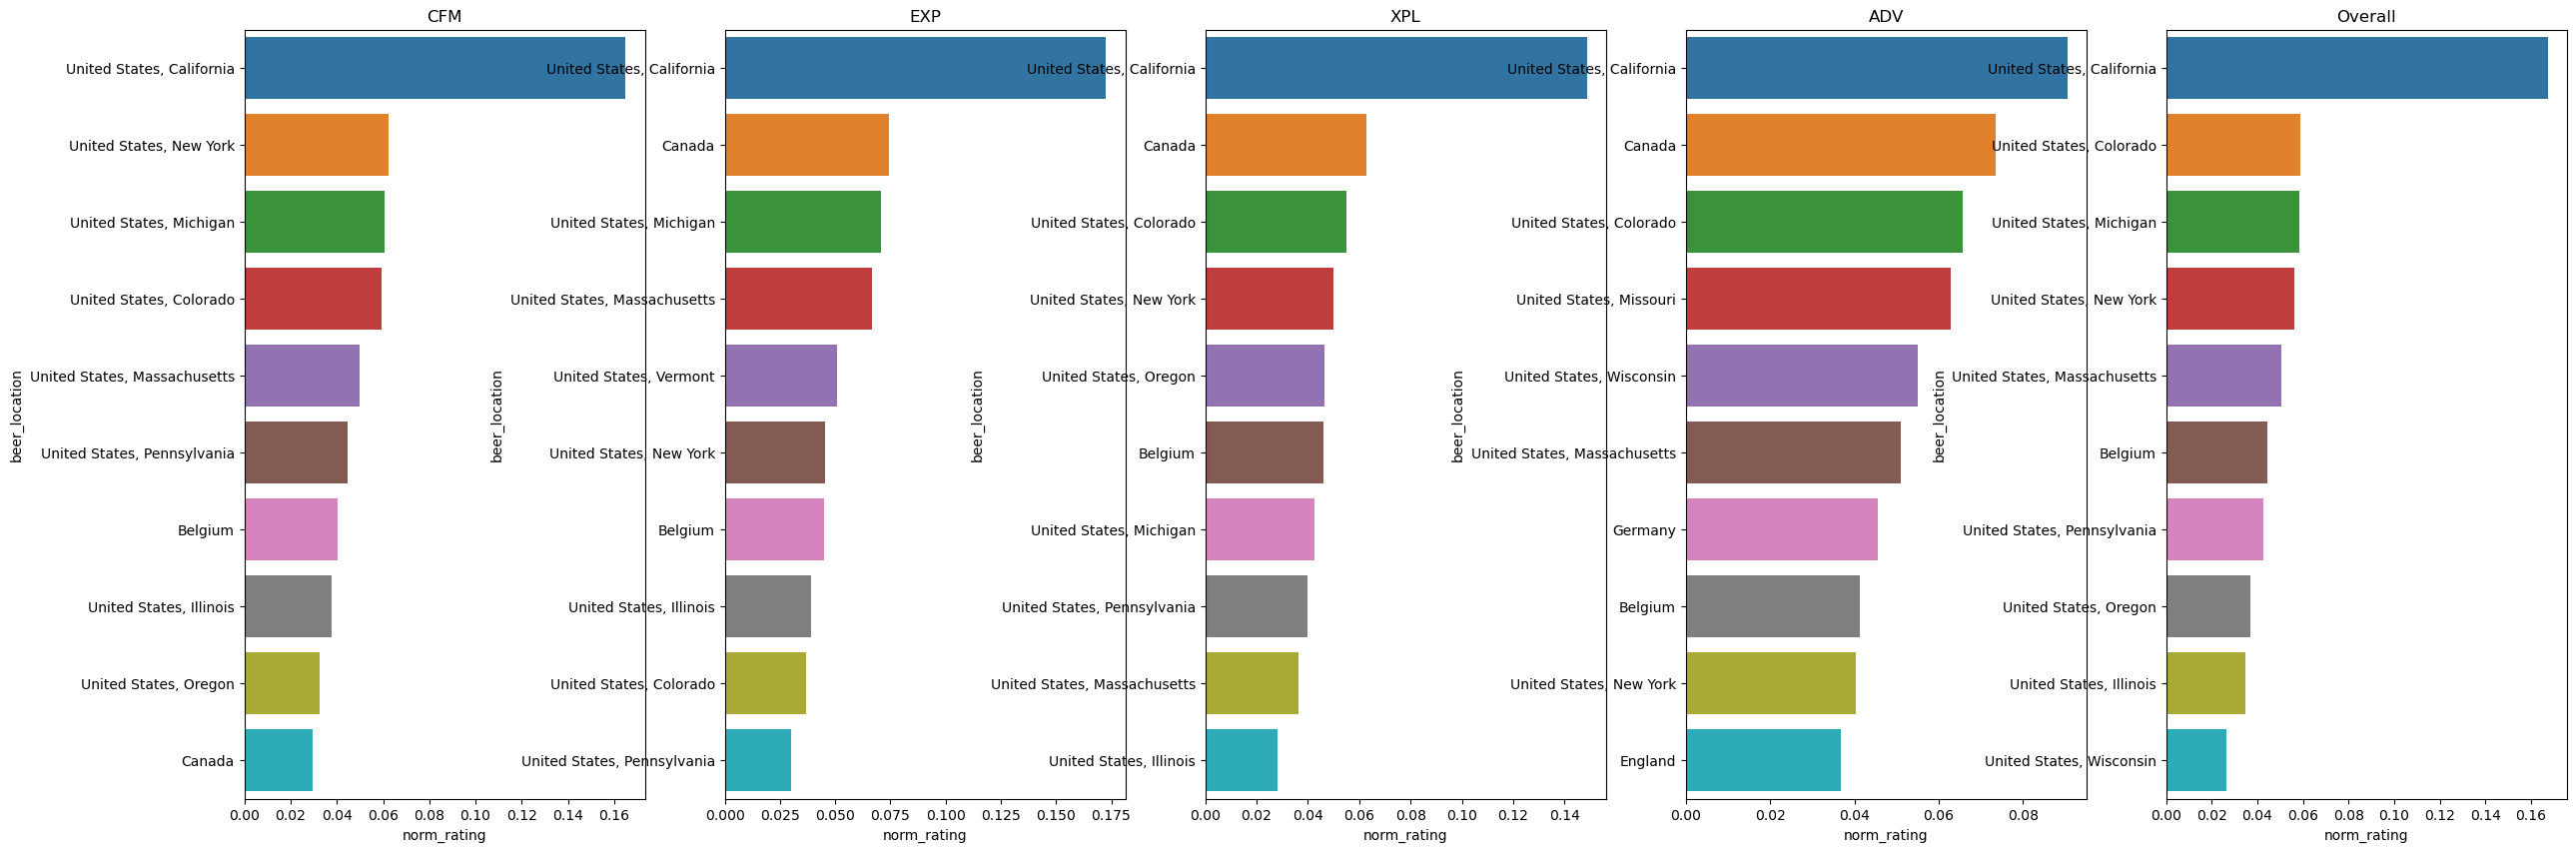

In [75]:
# plot top 10 locations for each category and overall using horizontal bar chart(seaborn)
fig, ax = plt.subplots(1, 5, figsize=(30, 10))
sns.barplot(x="norm_rating", y=cfm_ratings_by_location.index, data=cfm_ratings_by_location, ax=ax[0])
sns.barplot(x="norm_rating", y=exp_ratings_by_location.index, data=exp_ratings_by_location, ax=ax[1])
sns.barplot(x="norm_rating", y=xpl_ratings_by_location.index, data=xpl_ratings_by_location, ax=ax[2])
sns.barplot(x="norm_rating", y=adv_ratings_by_location.index, data=adv_ratings_by_location, ax=ax[3])
sns.barplot(x="norm_rating", y=overall_ratings_by_location.index, data=overall_ratings_by_location, ax=ax[4])
ax[0].set_title("CFM")
ax[1].set_title("EXP")
ax[2].set_title("XPL")
ax[3].set_title("ADV")
ax[4].set_title("Overall")
plt.show()



In [76]:
# same plot but interactive using plotly
fig = go.Figure()
fig.add_trace(go.Bar(
    x=cfm_ratings_by_location["norm_rating"],
    y=cfm_ratings_by_location.index,
    name="CFM",
    orientation='h',
))
fig.add_trace(go.Bar(
    x=exp_ratings_by_location["norm_rating"],
    y=exp_ratings_by_location.index,
    name="EXP",
    orientation='h',
))
fig.add_trace(go.Bar(
    x=xpl_ratings_by_location["norm_rating"],
    y=xpl_ratings_by_location.index,
    name="XPL",
    orientation='h',
))
fig.add_trace(go.Bar(
    x=adv_ratings_by_location["norm_rating"],
    y=adv_ratings_by_location.index,
    name="ADV",
    orientation='h',
))
fig.add_trace(go.Bar(
    x=overall_ratings_by_location["norm_rating"],
    y=overall_ratings_by_location.index,
    name="Overall",
    orientation='h',
))
fig.update_layout(barmode='group')
fig.show()


# What country do each category like most ?

In [134]:
# get average rating for each location for each category and overall
cfm_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_cfm"] == True]
exp_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_exp"] == True]
xpl_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_xpl"] == True]
adv_ratings_by_location = beers_breweries_ratings_scores_df[beers_breweries_ratings_scores_df["is_adv"] == True]
overall_ratings_by_location = beers_breweries_ratings_scores_df


cfm_ratings_by_location = cfm_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
exp_ratings_by_location = exp_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
xpl_ratings_by_location = xpl_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
adv_ratings_by_location = adv_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})
overall_ratings_by_location = overall_ratings_by_location.groupby("beer_location").agg({"rating": "mean"})


In [135]:
cfm_ratings_by_location

,rating
beer_location,
Albania,3.315556
Andorra,2.250000
Angola,2.800000
Antigua & Barbuda,2.847500
Argentina,2.926750
...,...
Vietnam,2.782828
Virgin Islands (British),3.000000
Virgin Islands (U.S.),3.220833


In [137]:
# filter out locations with less than 10 ratings using location_to_remove
cfm_ratings_by_location = cfm_ratings_by_location[~cfm_ratings_by_location.index.isin(cfm_locations_to_remove)]
exp_ratings_by_location = exp_ratings_by_location[~exp_ratings_by_location.index.isin(exp_locations_to_remove)]
xpl_ratings_by_location = xpl_ratings_by_location[~xpl_ratings_by_location.index.isin(xpl_locations_to_remove)]
adv_ratings_by_location = adv_ratings_by_location[~adv_ratings_by_location.index.isin(adv_locations_to_remove)]
overall_ratings_by_location = overall_ratings_by_location[~overall_ratings_by_location.index.isin(overall_locations_to_remove)]

In [139]:
exp_ratings_by_location

,rating
beer_location,
Australia,3.766667
Austria,3.936250
Belgium,4.614735
Canada,3.896453
China,4.350714
...,...
"United States, Vermont",4.745837
"United States, Virginia",4.163511
"United States, Washington",4.207939


In [140]:
# normalize by average rating overall
cfm_ratings_by_location = cfm_ratings_by_location['rating'] / cfm_ratings["rating"].mean()
exp_ratings_by_location = exp_ratings_by_location['rating'] / exp_ratings["rating"].mean()
xpl_ratings_by_location = xpl_ratings_by_location['rating'] / xpl_ratings["rating"].mean()
adv_ratings_by_location = adv_ratings_by_location['rating'] / adv_ratings["rating"].mean()
overall_ratings_by_location = overall_ratings_by_location / overall_ratings_by_location["rating"].mean()

In [141]:
# sort the the ratings series by rating
cfm_ratings_by_location = cfm_ratings_by_location.sort_values(ascending=False)
exp_ratings_by_location = exp_ratings_by_location.sort_values(ascending=False)
xpl_ratings_by_location = xpl_ratings_by_location.sort_values(ascending=False)
adv_ratings_by_location = adv_ratings_by_location.sort_values(ascending=False)
overall_ratings_by_location = overall_ratings_by_location.sort_values(by="rating", ascending=False)



# get top 10 locations for each category and overall
cfm_ratings_by_location = cfm_ratings_by_location[:10]
exp_ratings_by_location = exp_ratings_by_location[:10]
xpl_ratings_by_location = xpl_ratings_by_location[:10]
adv_ratings_by_location = adv_ratings_by_location[:10]
overall_ratings_by_location = overall_ratings_by_location[:10]

In [142]:
cfm_ratings_by_location

beer_location
United States, Iowa          1.070666
United States, Oklahoma      1.059062
Belgium                      1.044059
United States, Indiana       1.043010
United States, Vermont       1.040031
United States, California    1.029828
United States, Florida       1.028617
United States, Illinois      1.026992
United States, Ohio          1.026943
Sweden                       1.024932
Name: rating, dtype: float64

In [143]:
overall_ratings_by_location

,rating
beer_location,
"United States, Iowa",1.220965
"United States, Oklahoma",1.205451
Belgium,1.195245
"United States, Indiana",1.194791
"United States, Vermont",1.191763
"United States, California",1.178854
"United States, Florida",1.174832
"United States, Illinois",1.174581
"United States, Ohio",1.174336


In [144]:
fig = go.Figure()


fig.add_trace(go.Bar(
    y=cfm_ratings_by_location.values,
    x=cfm_ratings_by_location.index,
    name="CFM",
    orientation='v',
    marker_color='#FF0000'
))
fig.add_trace(go.Bar(
    y=exp_ratings_by_location.values,
    x=exp_ratings_by_location.index,
    name="EXP",
    orientation='v',
    marker_color='#00FF00'
))
fig.add_trace(go.Bar( 
    y=xpl_ratings_by_location.values,
    x=xpl_ratings_by_location.index,
    name="XPL",
    orientation='v',
    marker_color='#0000FF'
))
fig.add_trace(go.Bar(
    y=adv_ratings_by_location.values,
    x=adv_ratings_by_location.index,
    name="ADV",
    orientation='v',
    marker_color='#FFFF00'
))
fig.add_trace(go.Bar(
    y=overall_ratings_by_location["rating"].values,
    x=overall_ratings_by_location.index,
    name="Overall",
    orientation='v',
    marker_color='#000000'
))


fig.update_yaxes(range=[0.9, 1.2])

# set the x-axis to be the style names
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cfm_ratings_by_location.index})

# set the y-axis to be the percentage of ratings
fig.update_layout(yaxis_title="Percentage of Ratings")

# set the title
fig.update_layout(title_text="Top 10 rated beer styles for each Category")

fig.update_layout(barmode='group')
fig.show()

